In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import skew
%matplotlib inline

In this notebook, we will preprocess the data: deal with missing data, outliers, non-normal distribution, skewness, categorical variables, feature selection and feature engineering.

I will create various datasets after each step and fit the same model on each of them to see if it was an improvement.

# Import data

In [2]:
train = pd.read_csv("input/train.csv", header=0)
test  = pd.read_csv("input/test.csv", header=0)

# Deal with missing data (NaNs)

In [3]:
# concatenate all features (train + test)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [4]:
def print_missing(df):
    """
    print number of missing values and percent of missing values
    """  
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(40))
    

def fill_mode(df, column):
    """
    fill NaN values in column in df by the mode (most common observation)
    """    
    mode_value = df[column].dropna().mode().values 
    
    if len(df[column][df[column].isnull()]) > 0:    
        print('replace by mode: ', mode_value)
        df.loc[df[column].isnull(), column] = mode_value 


def fill_mean(df, column):    
    """
    fill NaN values in column in df by the mean of the column
    """   

    mean_value = df[column].dropna().mean()

    if len(df[column][df[column].isnull()]) > 0:
        print('replace by mean: ', mean_value)
        df.loc[df[column].isnull(), column] = mean_value


def fill_median(df, column):    
    """
    fill NaN values in column in df by the median of the column
    """   

    median_value = df[column].dropna().median()

    if len(df[column][df[column].isnull()]) > 0:
        print('replace by median: ', median_value)
        df.loc[df[column].isnull(), column] = median_value
        
def fill_value(df, column, val):    
    """
    fill NaN values in column in df by a specified value
    """   

    if len(df[column][df[column].isnull()]) > 0:
        print('replace by value: ', val)
        df.loc[df[column].isnull(), column] = val

In [5]:
print_missing(all_data)

              Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageCond      159  0.054471
GarageQual      159  0.054471
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471
GarageType      157  0.053786
BsmtCond         82  0.028092
BsmtExposure     82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
BsmtHalfBath      2  0.000685
Utilities         2  0.000685
Functional        2  0.000685
BsmtFullBath      2  0.000685
BsmtFinSF2        1  0.000343
BsmtFinSF1        1  0.000343
Exterior2nd       1  0.000343
BsmtUnfSF         1  0.000343
TotalBsmtSF       1  0.000343
Exterior1st       1  0.000343
SaleType          1  0.000343
Electrical        1  0.000343
KitchenQual       1  0.000343
GarageArea

If we look at the data_description.txt file, we see that NaN often mean that the characteristic described is not present. This is the case for Alley, BsmtQual, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature. So we will replace NaN by 'No'.

In [6]:
col_nan_list = ['Alley', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for col in col_nan_list:
    all_data[col].fillna('NO', inplace=True)

In [7]:
# If only a few missing observations + categorical variable: replace by the mode 
fill_mode(all_data, 'MSZoning')
fill_mode(all_data, 'MasVnrType')
fill_mode(all_data, 'Electrical')
fill_mode(all_data, 'Utilities')
fill_mode(all_data, 'Functional')
fill_mode(all_data, 'SaleType')
fill_mode(all_data, 'Utilities')
fill_mode(all_data, 'Exterior2nd')
fill_mode(all_data, 'Exterior1st')
fill_mode(all_data, 'KitchenQual')
fill_mode(all_data, 'GarageCars')
fill_mode(all_data, 'BsmtCond')
fill_mode(all_data, 'BsmtFullBath')
fill_mode(all_data, 'BsmtHalfBath')

replace by mode:  ['RL']
replace by mode:  ['None']
replace by mode:  ['SBrkr']
replace by mode:  ['AllPub']
replace by mode:  ['Typ']
replace by mode:  ['WD']
replace by mode:  ['VinylSd']
replace by mode:  ['VinylSd']
replace by mode:  ['TA']
replace by mode:  [2.]
replace by mode:  ['TA']
replace by mode:  [0.]
replace by mode:  [0.]


In [8]:
# for numerical variables: replace by the mean, the median (if a lot of outliers or skewed distribution) or use a prediction model
fill_mean(all_data, 'LotFrontage')      # normal distribution
fill_value(all_data, 'MasVnrArea', 0)   # lots of 0 so replace NaN by 0
fill_mean(all_data, 'BsmtUnfSF')        # normal distribution
fill_value(all_data, 'BsmtFinSF2', 0)   # lots of 0 so replace NaN by 0
fill_mean(all_data, 'TotalBsmtSF')      # normal distribution
fill_median(all_data, 'BsmtFinSF1')     # presence of outlier
fill_median(all_data, 'GarageYrBlt')    # replace by median year
fill_mean(all_data, 'GarageArea')       # normal distribution

replace by mean:  69.30579531442663
replace by value:  0
replace by mean:  560.7721041809458
replace by value:  0
replace by mean:  1051.7775873886224
replace by median:  368.5
replace by median:  1979.0
replace by mean:  472.8745716244003


In [9]:
print_missing(all_data)

               Total  Percent
SaleCondition      0      0.0
Foundation         0      0.0
RoofMatl           0      0.0
Exterior1st        0      0.0
Exterior2nd        0      0.0
MasVnrType         0      0.0
MasVnrArea         0      0.0
ExterQual          0      0.0
ExterCond          0      0.0
BsmtQual           0      0.0
YearRemodAdd       0      0.0
BsmtCond           0      0.0
BsmtExposure       0      0.0
BsmtFinType1       0      0.0
BsmtFinSF1         0      0.0
BsmtFinType2       0      0.0
BsmtFinSF2         0      0.0
BsmtUnfSF          0      0.0
RoofStyle          0      0.0
YearBuilt          0      0.0
Heating            0      0.0
Utilities          0      0.0
MSZoning           0      0.0
LotFrontage        0      0.0
LotArea            0      0.0
Street             0      0.0
Alley              0      0.0
LotShape           0      0.0
LandContour        0      0.0
LotConfig          0      0.0
OverallCond        0      0.0
LandSlope          0      0.0
Neighborho

No more missing values!

In [10]:
# separate train and test data and save files

clean_train = all_data.iloc[:train.shape[0], :]
clean_train = pd.concat([train['Id'], clean_train, train['SalePrice']], axis=1)

clean_test = all_data.iloc[train.shape[0]:, :]
clean_test = pd.concat([test['Id'], clean_test], axis=1)

clean_train.to_csv('input/train_noMissing.csv', index=False)
clean_test.to_csv('input/test_noMissing.csv', index=False)

# Deal with collinear features
From the first notebook, we noticed collinear features. Let's delete them.

In [11]:
clean_train = train.drop(['GarageArea', '1stFlrSF', 'GarageYrBlt'], axis=1)
clean_test = test.drop(['GarageArea', '1stFlrSF', 'GarageYrBlt'], axis=1)

In [12]:
clean_train.to_csv('input/train_noColinear.csv', index=False)
clean_test.to_csv('input/test_noColinear.csv', index=False)

# Deal with outliers

In [13]:
# standardizing data: converting data values to have mean of 0 and a standard deviation of 1.
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('outer range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]
outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


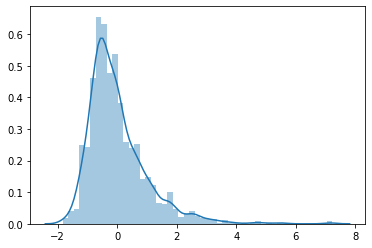

In [14]:
sns.distplot(saleprice_scaled)

We notice 2 very high values above 7, they are likely to be outliers. For now, let's have a look again at the bivariate plots from the previous notebook. We can remove the observations that we (subjectively) deem to be outliers.

In [15]:
def plot_bivariate(df, col):
    """ plot scatter or boxplot of SalePrice vs col """
 
    if df[col].dtypes == object: 
        # for categorical variables
        sns.boxplot(x=col, y='SalePrice', data=df)

    else:
        # for numerical variables
        df.plot.scatter(x=col, y='SalePrice') #, ylim=(0,800000))

    plt.xlabel(col)

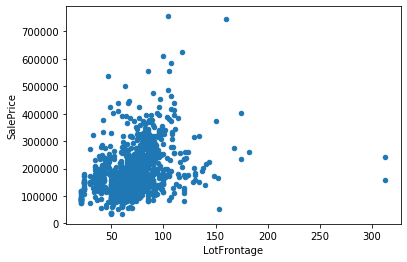

In [16]:
plot_bivariate(train, 'LotFrontage')

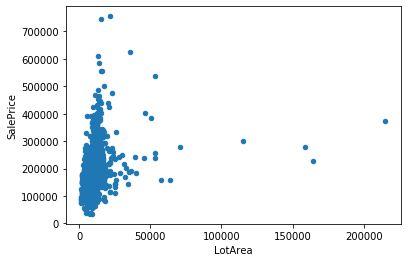

In [17]:
plot_bivariate(train, 'LotArea')

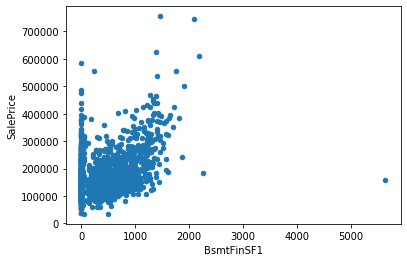

In [18]:
plot_bivariate(train, 'BsmtFinSF1')

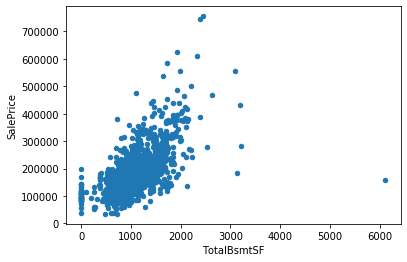

In [19]:
plot_bivariate(train, 'TotalBsmtSF')

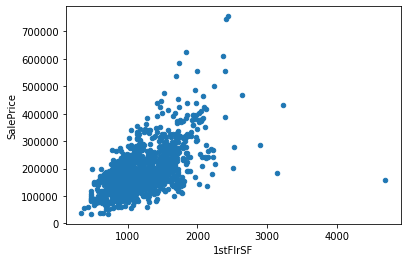

In [20]:
plot_bivariate(train, '1stFlrSF')

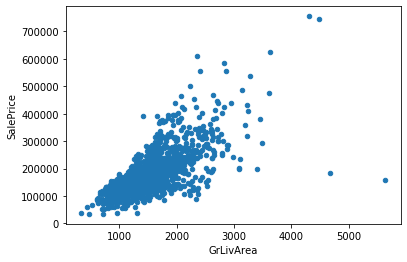

In [21]:
plot_bivariate(train, 'GrLivArea')

In [22]:
train = train.drop(train[train.LotFrontage > 300].index)
train = train.drop(train[train.LotArea > 100000].index)
train = train.drop(train[train.BsmtFinSF1 > 5000].index)
train = train.drop(train[train.TotalBsmtSF > 5900].index)
train = train.drop(train[train.GrLivArea > 4500].index)

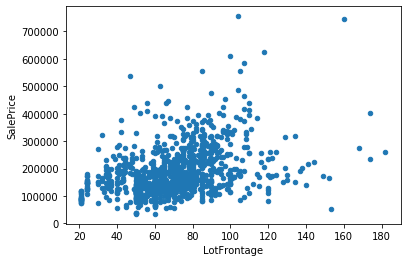

In [23]:
plot_bivariate(train, 'LotFrontage')

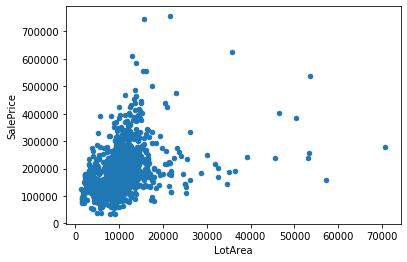

In [24]:
plot_bivariate(train, 'LotArea')

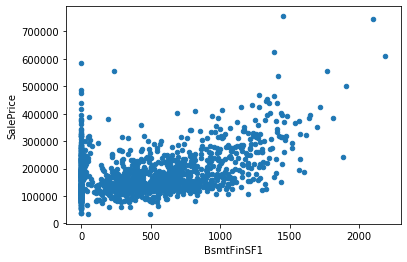

In [25]:
plot_bivariate(train, 'BsmtFinSF1')

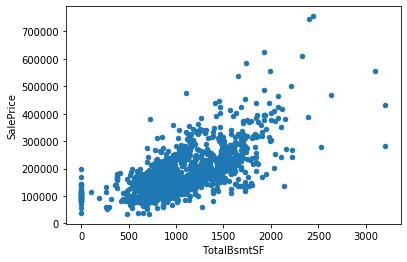

In [26]:
plot_bivariate(train, 'TotalBsmtSF')

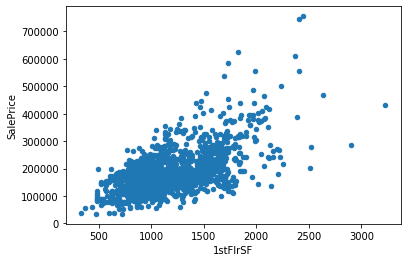

In [27]:
plot_bivariate(train, '1stFlrSF')

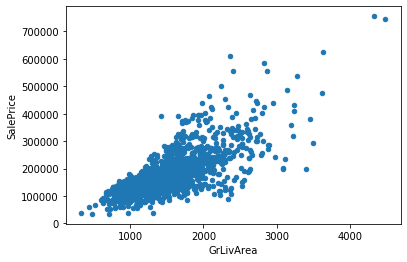

In [28]:
plot_bivariate(train, 'GrLivArea')

In [29]:
train.to_csv('input/train_noOutliers.csv', index=False)
train = pd.read_csv("input/train.csv", header=0)  # import train again

# Feature engineering: Deal with normality and skewness

Ideally, the features should follow these 4 characteristics:

1. Normality

The features should follow a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

2. Homoscedasticity

Homoscedasticity refers to the assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

3. Linearity

The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

4. Absence of correlated errors

Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

## Deal with normality

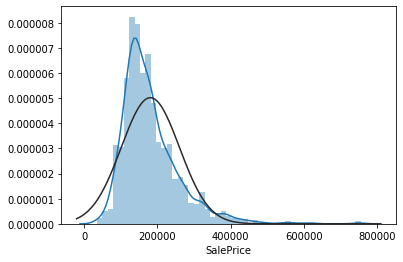

In [30]:
sns.distplot(train['SalePrice'], fit=norm)

The histogram shows that SalePrice has a positive kurtosis and a positive skewness.

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

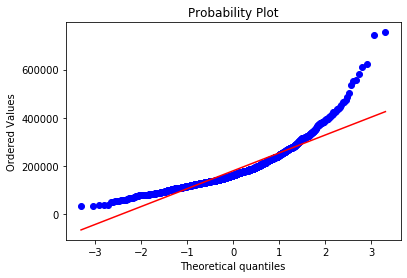

In [31]:
stats.probplot(train['SalePrice'], plot=plt)

Normal probability plot: the data distribution should closely follow the diagonal that represents the normal distribution, which is not the case. In case of positive skewness, log transformations usually works well.

In [32]:
print("Skewness: %f" % train['SalePrice'].skew())

Skewness: 1.882876


In [33]:
train['SalePrice'] = np.log1p(train['SalePrice'])

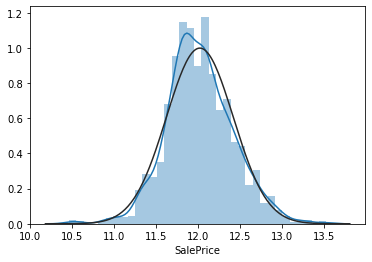

In [34]:
sns.distplot(train['SalePrice'], fit=norm)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.3982596466541509, 12.024057394918403, 0.9953761551826702))

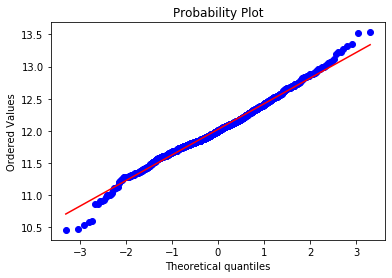

In [35]:
stats.probplot(train['SalePrice'], plot=plt)

In [36]:
print("Skewness: %f" % train['SalePrice'].skew())

Skewness: 0.121347


Done! Let's do the same for GrLivArea.

In [37]:
# First, concatenate all features (train + test)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

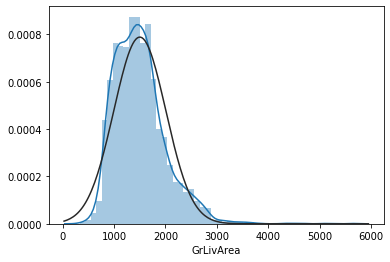

In [38]:
sns.distplot(all_data['GrLivArea'], fit=norm)

((array([-3.49454834, -3.25034572, -3.11527604, ...,  3.11527604,
          3.25034572,  3.49454834]),
  array([ 334,  407,  438, ..., 4676, 5095, 5642])),
 (489.28523128867596, 1500.7598492634463, 0.9659918130329509))

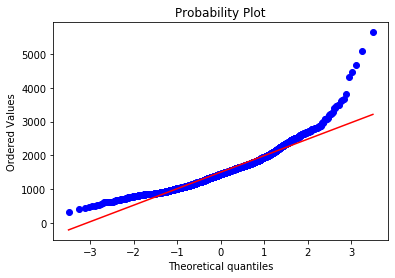

In [39]:
stats.probplot(all_data['GrLivArea'], plot=plt)

In [40]:
print("Skewness: %f" % all_data['GrLivArea'].skew())

Skewness: 1.270010


In [41]:
all_data['GrLivArea'] = np.log1p(all_data['GrLivArea'])

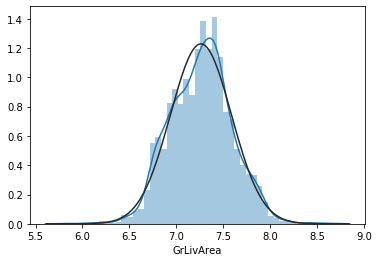

In [42]:
sns.distplot(all_data['GrLivArea'], fit=norm)

((array([-3.49454834, -3.25034572, -3.11527604, ...,  3.11527604,
          3.25034572,  3.49454834]),
  array([5.81413053, 6.01126717, 6.08449941, ..., 8.45041216, 8.5362112 ,
         8.63817112])),
 (0.3244949956776744, 7.26150229237396, 0.9983089191253876))

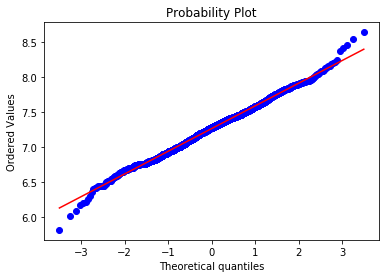

In [43]:
stats.probplot(all_data['GrLivArea'], plot=plt)

In [44]:
print("Skewness: %f" % all_data['GrLivArea'].skew())

Skewness: 0.013194


Now for TotalBsmtSF, we have a problem: there's a lot of observations with a value of zero and we can't apply a log transform here. 

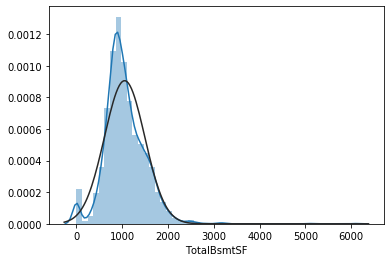

In [45]:
sns.distplot(all_data['TotalBsmtSF'], fit=norm)

((array([-3.49454834, -3.25034572, -3.11527604, ...,  3.11527604,
          3.25034572,  3.49454834]),
  array([   0.,    0.,    0., ..., 5095., 6110.,   nan])),
 (nan, nan, nan))

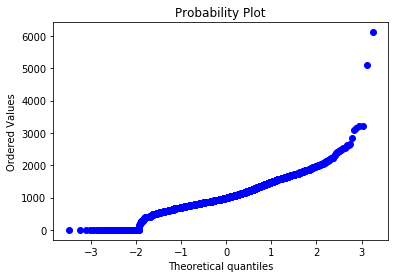

In [46]:
stats.probplot(all_data['TotalBsmtSF'], plot=plt)

In [47]:
print("Skewness: %f" % all_data['TotalBsmtSF'].skew())

Skewness: 1.162882


To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

In [48]:
# create column for new variable (one is enough because it's a binary categorical feature)
# if area>0 it gets 1, for area==0 it gets 0
all_data['HasBsmt'] = pd.Series(len(all_data['TotalBsmtSF']), index=all_data.index)
all_data['HasBsmt'] = 0 
all_data.loc[all_data['TotalBsmtSF']>0,'HasBsmt'] = 1

In [49]:
all_data.loc[all_data['HasBsmt']==1,'TotalBsmtSF'] = np.log1p(all_data.loc[all_data['HasBsmt']==1,'TotalBsmtSF'])

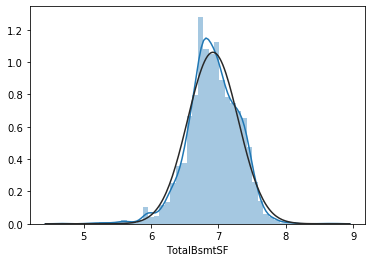

In [50]:
sns.distplot(all_data[all_data['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm)

((array([-3.4872186 , -3.2425367 , -3.10717558, ...,  3.10717558,
          3.2425367 ,  3.4872186 ]),
  array([4.66343909, 5.08140436, 5.1590553 , ..., 8.0730912 , 8.5362112 ,
         8.7178457 ])),
 (0.37305007241748894, 6.918064397099972, 0.9911913640585924))

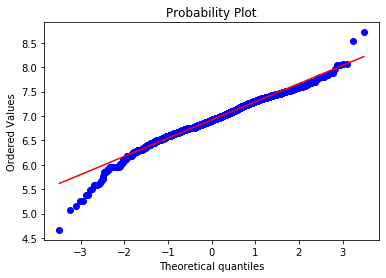

In [51]:
stats.probplot(all_data[all_data['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

In [52]:
print("Skewness: %f" % all_data['TotalBsmtSF'].skew())

Skewness: -4.983345


In [53]:
# check skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))  # compute skewness 
skewed_feats = skewed_feats[skewed_feats > 0.75]     # select variables with skew > 0.75

In [54]:
skewed_feats

MSSubClass        1.375457
LotFrontage       1.502351
LotArea          12.822431
MasVnrArea        2.601240
BsmtFinSF1        1.424989
BsmtFinSF2        4.145323
BsmtUnfSF         0.919351
1stFlrSF          1.469604
2ndFlrSF          0.861675
LowQualFinSF     12.088761
BsmtHalfBath      3.929996
KitchenAbvGr      4.302254
TotRmsAbvGrd      0.758367
WoodDeckSF        1.842433
OpenPorchSF       2.535114
EnclosedPorch     4.003891
3SsnPorch        11.376065
ScreenPorch       3.946694
PoolArea         16.898328
MiscVal          21.947195
dtype: float64

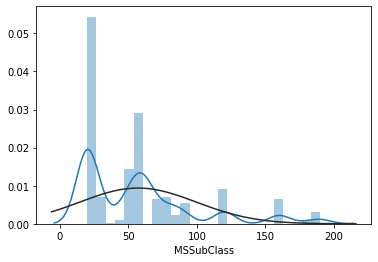

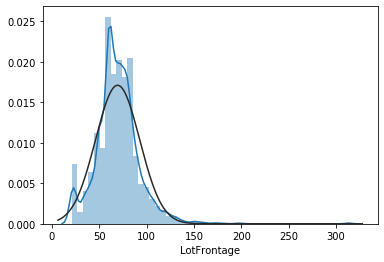

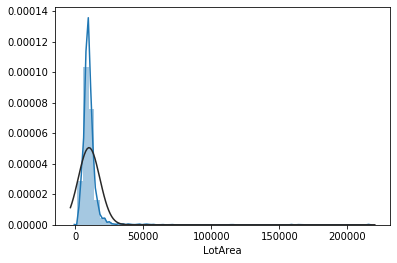

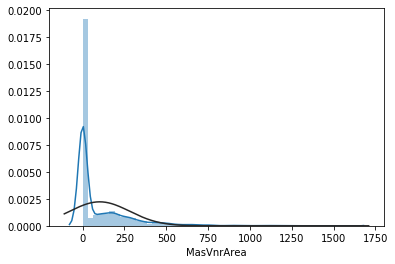

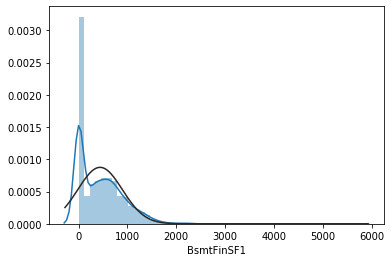

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


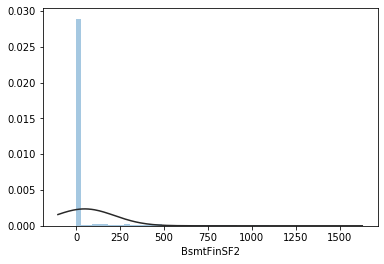

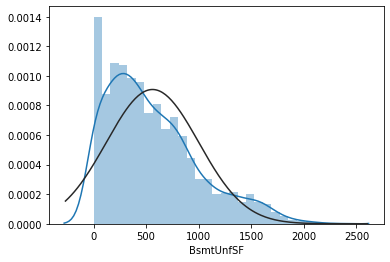

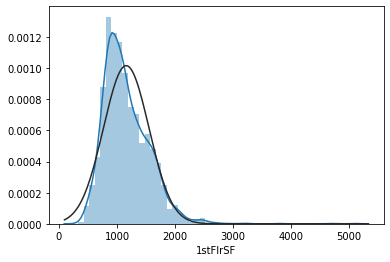

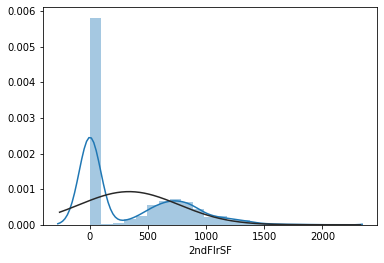

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


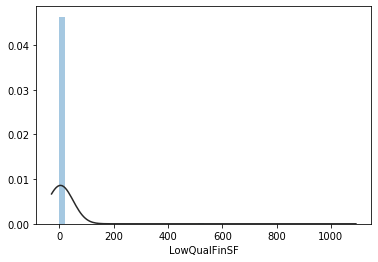

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


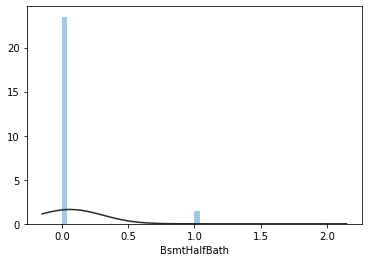

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


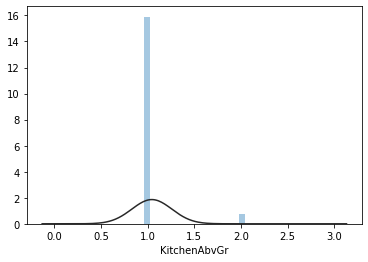

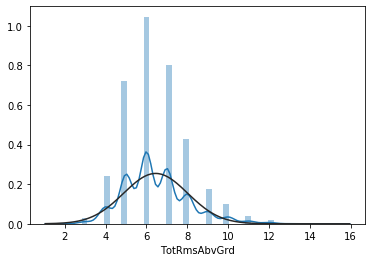

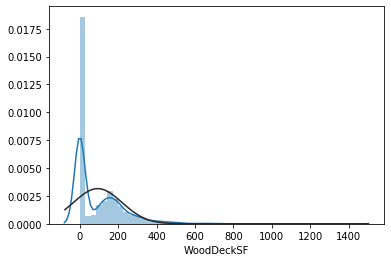

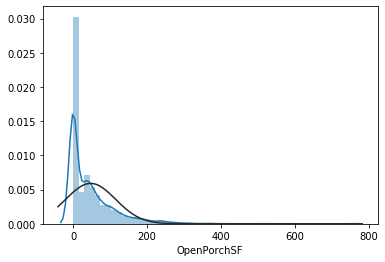

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


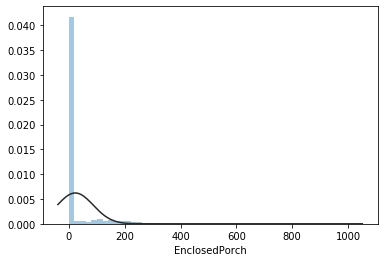

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


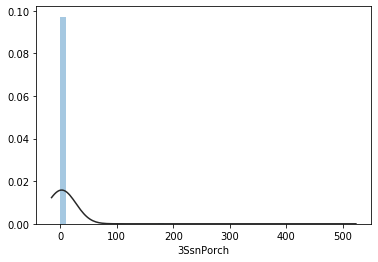

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


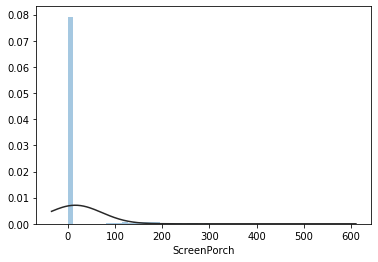

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


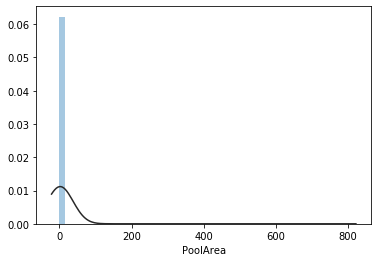

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


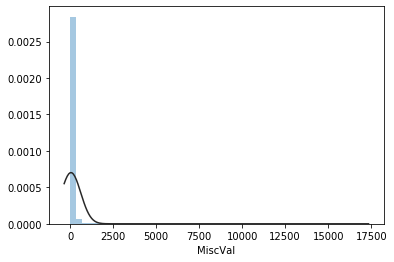

In [55]:
for col in skewed_feats.index:
    sns.distplot(all_data[col], fit=norm)
    plt.show()

MSSubClass, KitchenAbvGr, TotRmsAbvGrd are categorical variables, it doesn't make sense to apply a log transform.
LowQualFinSF, BsmtFinSF2, LowQualFinSF, BsmtHalfBath, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal have too may zeros so we'll exclude them as well.

In [56]:
skewed_feats.drop(['MSSubClass', 'KitchenAbvGr', 'TotRmsAbvGrd', 'LowQualFinSF', 'BsmtHalfBath', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'], inplace=True)

In [57]:
skewed_feats

LotFrontage     1.502351
LotArea        12.822431
MasVnrArea      2.601240
BsmtFinSF1      1.424989
BsmtFinSF2      4.145323
BsmtUnfSF       0.919351
1stFlrSF        1.469604
2ndFlrSF        0.861675
WoodDeckSF      1.842433
OpenPorchSF     2.535114
dtype: float64

In [58]:
for col in skewed_feats.index:
    all_data[col] = np.log1p(all_data[col])

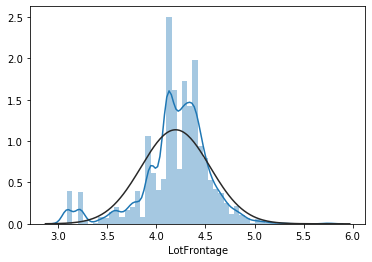

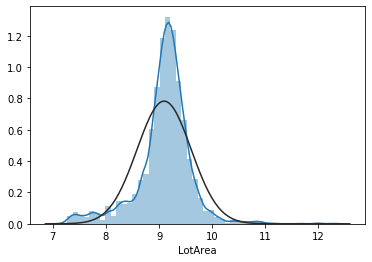

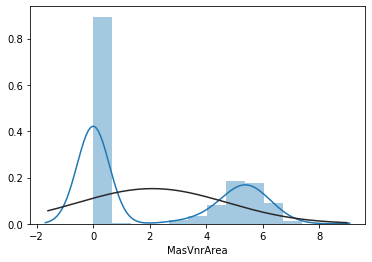

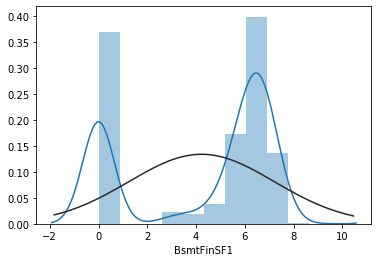

/home/pierre/bin/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


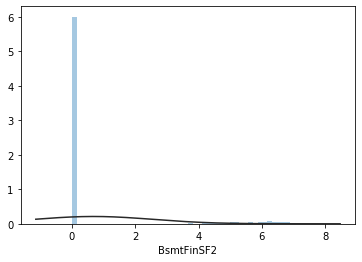

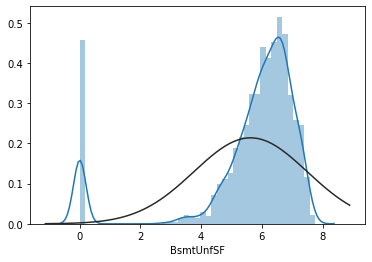

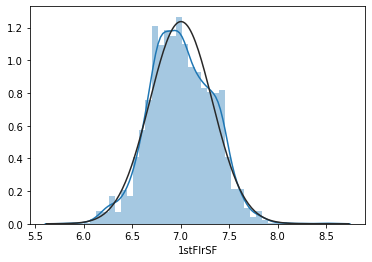

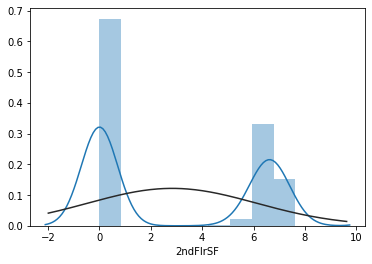

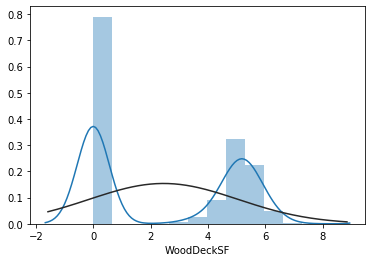

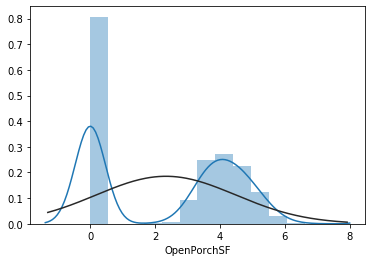

In [59]:
for col in skewed_feats.index:
    sns.distplot(all_data[col], fit=norm)
    plt.show()

In [60]:
# separate train and test data and save files

clean_train = all_data.iloc[:train.shape[0], :]
clean_train = pd.concat([train['Id'], clean_train, train['SalePrice']], axis=1)

clean_test = all_data.iloc[train.shape[0]:, :]
clean_test = pd.concat([test['Id'], clean_test], axis=1)

clean_train.to_csv('input/train_logTranform.csv', index=False)
clean_test.to_csv('input/test_logTranform.csv', index=False)

## Deal with homoscedasticity

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

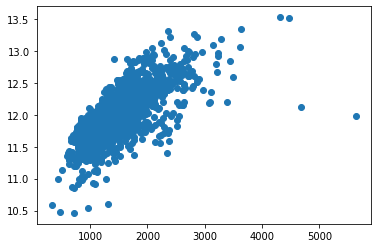

In [61]:
plt.scatter(train['GrLivArea'], train['SalePrice'])

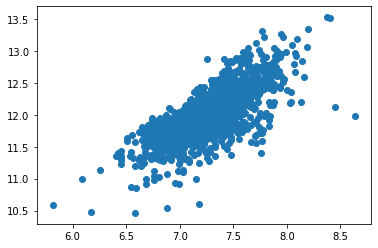

In [62]:
plt.scatter(clean_train['GrLivArea'], clean_train['SalePrice'])

After applying the log transform (and making the distribution more 'normal'), the variance for both features seem to be equal. We don't need to correct the homoscedasticity for these variables.

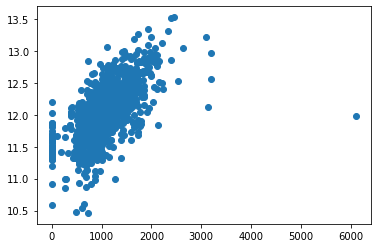

In [63]:
plt.scatter(train['TotalBsmtSF'], train['SalePrice'])

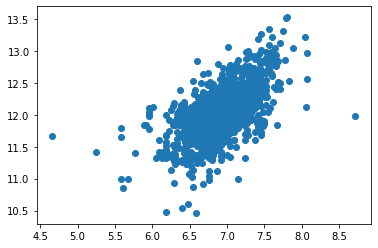

In [64]:
plt.scatter(clean_train[clean_train['TotalBsmtSF']>0]['TotalBsmtSF'], clean_train[clean_train['TotalBsmtSF']>0]['SalePrice'])

Same conclusion here.

## Deal with categorical variables

In [65]:
# concatenate all features (train + test)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [66]:
# convert categorical variable into dummy
all_data = pd.get_dummies(all_data)

In [67]:
# separate train and test data and save files

clean_train = all_data.iloc[:train.shape[0], :]
clean_train = pd.concat([train['Id'], clean_train, train['SalePrice']], axis=1)

clean_test = all_data.iloc[train.shape[0]:, :]
clean_test = pd.concat([test['Id'], clean_test], axis=1)

clean_train.to_csv('input/train_dummy.csv', index=False)
clean_test.to_csv('input/test_dummy.csv', index=False)

# All data preprocessing combined

In [68]:
train = pd.read_csv("input/train.csv", header=0)
test  = pd.read_csv("input/test.csv", header=0)

In [69]:
# Collinear features
train = train.drop(['GarageArea', '1stFlrSF', 'GarageYrBlt'], axis=1)
test = test.drop(['GarageArea', '1stFlrSF', 'GarageYrBlt'], axis=1)

In [70]:
# outliers
train = train.drop(train[train.LotFrontage > 300].index)
train = train.drop(train[train.LotArea > 100000].index)
train = train.drop(train[train.BsmtFinSF1 > 5000].index)
train = train.drop(train[train.TotalBsmtSF > 5900].index)
train = train.drop(train[train.GrLivArea > 4500].index)

In [71]:
# normality of SalePrice
train['SalePrice'] = np.log1p(train['SalePrice'])

In [72]:
# concatenate all features (train + test)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [73]:
# missing values
col_nan_list = ['Alley', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for col in col_nan_list:
    all_data[col].fillna('NO', inplace=True)
    
# If only a few missing observations + categorical variable: replace by the mode     
fill_mode(all_data, 'MSZoning')
fill_mode(all_data, 'MasVnrType')
fill_mode(all_data, 'Electrical')
fill_mode(all_data, 'Utilities')
fill_mode(all_data, 'Functional')
fill_mode(all_data, 'SaleType')
fill_mode(all_data, 'Utilities')
fill_mode(all_data, 'Exterior2nd')
fill_mode(all_data, 'Exterior1st')
fill_mode(all_data, 'KitchenQual')
fill_mode(all_data, 'GarageCars')
fill_mode(all_data, 'BsmtCond')
fill_mode(all_data, 'BsmtFullBath')
fill_mode(all_data, 'BsmtHalfBath')

# for numerical variables: replace by the mean, the median (if a lot of outliers or skewed distribution) or use a prediction model
fill_mean(all_data, 'LotFrontage')      # normal distribution
fill_value(all_data, 'MasVnrArea', 0)   # lots of 0 so replace NaN by 0
fill_mean(all_data, 'BsmtUnfSF')        # normal distribution
fill_value(all_data, 'BsmtFinSF2', 0)   # lots of 0 so replace NaN by 0
fill_mean(all_data, 'TotalBsmtSF')      # normal distribution
fill_median(all_data, 'BsmtFinSF1')     # presence of outlier

# Make feature distribution normal
all_data['GrLivArea'] = np.log1p(all_data['GrLivArea'])

all_data['HasBsmt'] = pd.Series(len(all_data['TotalBsmtSF']), index=all_data.index)
all_data['HasBsmt'] = 0 
all_data.loc[all_data['TotalBsmtSF']>0,'HasBsmt'] = 1
all_data.loc[all_data['HasBsmt']==1,'TotalBsmtSF'] = np.log1p(all_data.loc[all_data['HasBsmt']==1,'TotalBsmtSF'])

col_log = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF']

for col in col_log:
    all_data[col] = np.log1p(all_data[col])

# convert categorical variable into dummy
all_data = pd.get_dummies(all_data)

# separate train and test data and save files
clean_train = all_data.iloc[:train.shape[0], :]
clean_train = pd.concat([train['Id'], clean_train, train['SalePrice']], axis=1)

clean_test = all_data.iloc[train.shape[0]:, :]
clean_test = pd.concat([test['Id'], clean_test], axis=1)

clean_train.to_csv('input/train_cleaned.csv', index=False)
clean_test.to_csv('input/test_cleaned.csv', index=False)

replace by mode:  ['RL']
replace by mode:  ['None']
replace by mode:  ['SBrkr']
replace by mode:  ['AllPub']
replace by mode:  ['Typ']
replace by mode:  ['WD']
replace by mode:  ['VinylSd']
replace by mode:  ['VinylSd']
replace by mode:  ['TA']
replace by mode:  [2.]
replace by mode:  ['TA']
replace by mode:  [0.]
replace by mode:  [0.]
replace by mean:  69.04693289419514
replace by value:  0
replace by mean:  561.1387839230505
replace by value:  0
replace by mean:  1048.619718309859
replace by median:  368.0
